In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
# Python
df = pd.read_csv('LB_Forecast_Cash_7.csv')
df.head()

,Year,Week,ds,y,Recievables
0,2022,1,1/3/2022,1347047,216637
1,2022,2,1/10/2022,1348548,220002
2,2022,3,1/17/2022,1362683,186054
3,2022,4,1/24/2022,1297296,291930
4,2022,5,1/31/2022,1328903,298269


In [4]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
df.fillna(df.mean(), inplace=True)

In [6]:
df[:] = np.nan_to_num(df)

In [18]:
df.isnull().sum()

Year           0
Week           0
ds             0
y              0
Recievables    0
dtype: int64

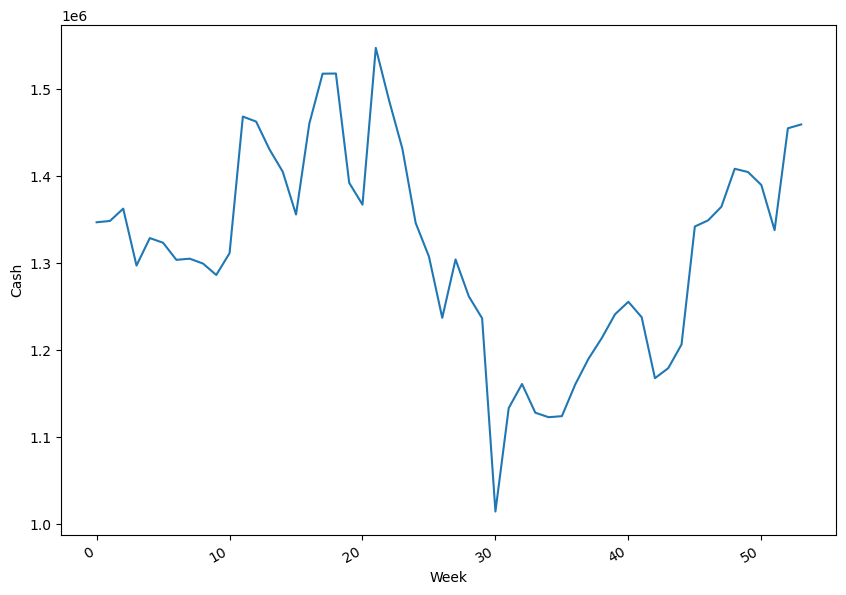

In [7]:
fig, ax = plt.subplots()

ax.plot(df['y'])
ax.set_xlabel('Week')

ax.set_ylabel('Cash')

fig.autofmt_xdate()

In [8]:
train = df[:-36]
test = df[-36:]

In [9]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in 
         product(*param_grid.values())]

mses = []

In [10]:
cutoffs = pd.date_range(start='2022-01-03', end='2023-01-13', freq='12M')

In [11]:
for param in params:
    m = Prophet(**param)
    m.fit(train)
    
    df_cv = cross_validation(model=m, horizon='31 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['mse']=mses

best_params = params[np.argmin(mses)]
print(best_params)

21:01:13 - cmdstanpy - INFO - Chain [1] start processing
21:01:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:13 - cmdstanpy - INFO - Chain [1] start processing
21:01:13 - cmdstanpy - INFO - Chain [1] done processing
21:01:14 - cmdstanpy - INFO - Chain [1] start processing
21:01:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:14 - cmdstanpy - INFO - Chain [1] start processing
21:01:14 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:16 - cmdstanpy - INFO - Chain [1] start processing
21:01:16 - cmdstanpy - INFO - Chain [1] done processing
21:01:16 - cmdstanpy - INFO - Chain [1] start processing
21:01:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:16 - cmdstanpy - INFO - Chain [1] start processing
21:01:17 - cmdstanpy - INFO - Chain [1] done processing
21:01:17 - cmdstanpy - INFO - Chain [1] start processing
21:01:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:17 - cmdstanpy - INFO - Chain [1] start processing
21:01:17 - cmdstanpy - INFO - Chain [1] done processing
21:01:18 - cmdstanpy - INFO - Chain [1] start processing
21:01:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:18 - cmdstanpy - INFO - Chain [1] start processing
21:01:22 - cmdstanpy - INFO - Chain [1] done processing
21:01:23 - cmdstanpy - INFO - Chain [1] start processing
21:01:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:23 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:31 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


In [12]:
m = Prophet(**best_params)
m.fit(train);

21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
future = m.make_future_dataframe(periods=12, freq='M')

In [14]:
forecast = m.predict(future)

In [15]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat','yhat_lower','yhat_upper']]

In [16]:
test['Baseline'] = train['y'].iloc[-1]

In [31]:
baseline_mae = mean_absolute_error(test['y'], test['Baseline'])
print(baseline_mae)

228005.16666666666


In [37]:
prophet_mae = mean_absolute_error(test['y'], test['y'])
print(prophet_mae)

0.0


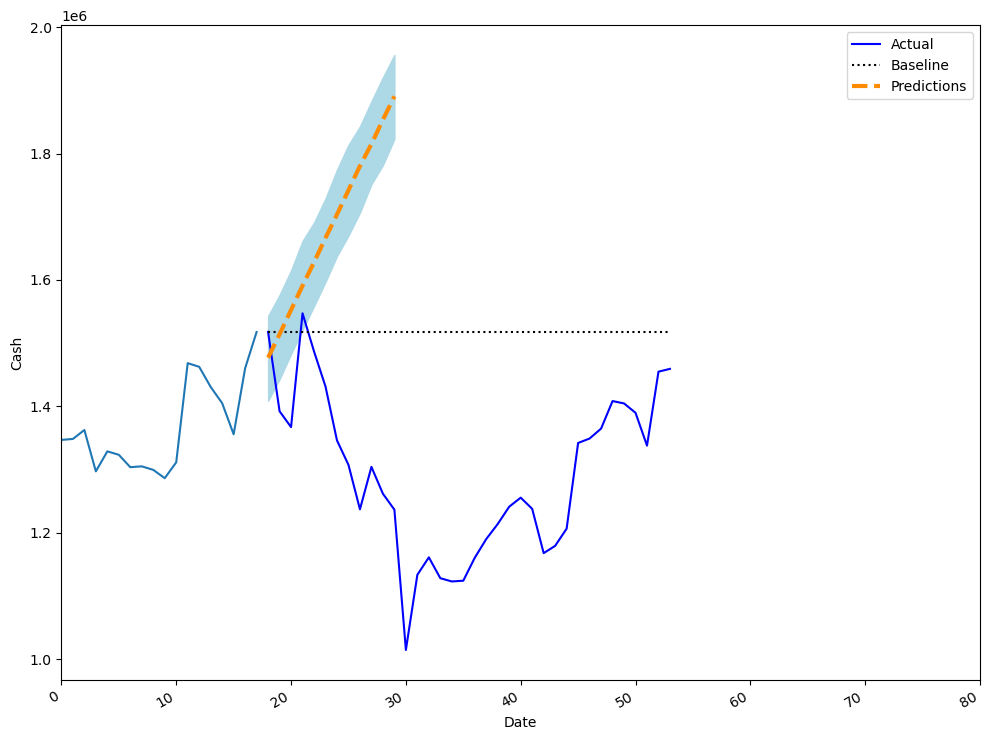

In [29]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['Baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, 
        label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Cash')

ax.axvspan(287, 322, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')

plt.xlim(0, 80)

fig.autofmt_xdate()
plt.tight_layout()

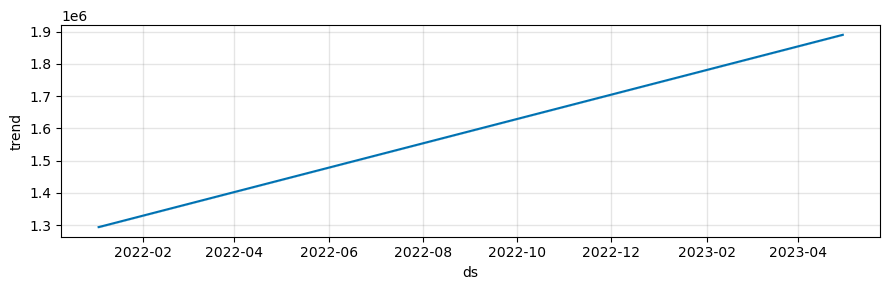

In [27]:
prophet_components_fig = m.plot_components(forecast)